# Thermodynamic and dynamic contributions

In [2]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import glob
import atmotrans as atm

## ERA5 

In [53]:
###  seasonal means  ###
time = np.arange(1979,2020)
f= '../moisture_transport/moisture_transport/cache/srfc-monthly/moistdiv_annual_means.nc'
m = xr.open_dataset(f)
mfc = - m['vimd'][:,:-1,:-1] 
mfc_clim = np.nanmean(mfc.values, axis = 0)
f= '../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-monthly-climatology.nc'
climatology = xr.open_dataset(f)
pressure = climatology.level.values
# surface pressure files for each year 
sp_files= glob.glob('../moisture_transport/moisture_transport/cache/srfc-monthly/*surface_pressure_????.nc')
sp_files.sort()
# spacing 
dlat,dlon = atm.get_spacing(climatology.latitude.values, climatology.longitude.values)

### anomalies ###
f= '../moisture_transport/moisture_transport/cache/srfc-monthly/moistdiv_anomalies.nc'
data = xr.open_dataset(f)
mfc_anom = data['vimd'][:,:-1,:-1] 
anomalies = glob.glob('../moisture_transport/moisture_transport/cache/pressure-monthly/*anomaly*.nc')
anomalies.sort()

In [31]:
def column_integration(data, sp, qu):
    from scipy import interpolate
    import wrf 
    coords = np.where(sp < 10000)
    pressure = np.zeros((37,201, 321))
    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]

        pressure[:,ilat,ilon]= data.level.values
        pressure[28, :, :] =  sp
        idx, pl = atm.find_nearest_idx(data.level.values, sp_value)

        # function for extrapolation/ interpolation: 
        x_vals = data.level.values
        y_vals= qu[:,ilat,ilon]
        f = interpolate.interp1d(x_vals, y_vals, fill_value = "extrapolate", kind = 'cubic')

        # set q value below ground to 0 
        if sp_value < 1000:
            if sp_value > pl:
                idx = idx + 1  
            pressure[idx, ilat,ilon] = sp_value
            qu[idx:37, ilat, ilon] =  0

        if sp_value > 1000:
            qu[36, ilat, ilon] = f(sp_value)

    colint = atm.colint_pressure(qu, pressure)

    return colint

In [ ]:
thermodynamic_tp= np.array(())
dynamic_tp = np.array(())
thermodynamic_land= np.array(())
dynamic_land = np.array(())
thermodynamic_con = np.array(())
dynamic_con = np.array(())
thermodynamic_div = np.array(())
dynamic_div = np.array(()) 

# read in files for each year 
for y in np.arange(41): 
    print(anomalies[y])
    # clim values 
    q_c= climatology.q[0].values
    u_c = climatology.u[0].values
    v_c= climatology.v[0].values
    ds = xr.open_dataset(anomalies[y])
    sp = xr.open_dataset(sp_files[y]).sp[0].values / 100
    q_a= ds.q[0].values
    u_a= ds.u[0].values
    v_a= ds.v[0].values
    ds.close()
        
    # product for thermodynamic and dynamic component 
    qc_ua = q_c* u_a 
    qc_va = q_c* v_a
        
    qa_uc = q_a*u_c
    qa_vc = q_a*v_c

    # column-integration   
    dyna_u = column_integration(climatology, sp, qc_ua)
    dyna_v = column_integration(climatology, sp, qc_va)
    thermo_u = column_integration(climatology, sp, qa_uc)
    thermo_v = column_integration(climatology, sp, qa_vc)
    
    # divergence 
    thermo= atm.divergence(climatology,thermo_u, thermo_v)
    dyna = atm.divergence(climatology, dyna_u, dyna_v)

    # calculate regional averages and append to timeseries 
    th_tp, th_land, th_con, th_div =  mask_region(thermo)
    dy_tp, dy_land, dy_con, dy_div  =  mask_region(dyna)
    
    # append to annual timeseries 
    thermodynamic_tp = np.append(thermodynamic_tp,th_tp)
    dynamic_tp = np.append(dynamic_tp,dy_tp)
    
    thermodynamic_land = np.append(thermodynamic_land,th_land)
    dynamic_land = np.append(dynamic_land,dy_land)
    
    thermodynamic_con = np.append(thermodynamic_con,th_con)
    dynamic_con = np.append(dynamic_con,dy_con)
    
    thermodynamic_div = np.append(thermodynamic_div,th_div)
    dynamic_div = np.append(dynamic_div,dy_div)


../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1979.nc
../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1980.nc
../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1981.nc
../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1982.nc
../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1983.nc
../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1984.nc
../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1985.nc
../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1986.nc
../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomaly-1987.nc
../moisture_transport/moisture_transport/cache/pressure-monthly/era5-pressure-levels-anomal

In [152]:
thermodynamic_tp

array([-0.10494225, -0.02701485, -0.0513877 , -0.11504965, -0.00179665,
        0.01970581, -0.13459263, -0.03398464, -0.12874098,  0.06641511,
       -0.1021296 ,  0.0604119 ,  0.03693731, -0.03864521, -0.06084392,
        0.08136555, -0.00865398,  0.04199479, -0.00884027,  0.06743067,
        0.00829156,  0.05948967,  0.00765407,  0.04633076, -0.04806382,
       -0.08481087, -0.07154476,  0.0243851 ,  0.02850949,  0.07381937,
       -0.18131834,  0.17807317,  0.0840926 ,  0.00594631,  0.03877653,
       -0.08773226,  0.03711319,  0.12027757,  0.1068146 ,  0.05556926,
        0.04109332])

## WRF

In [183]:
###  CLIMATOLOGY ###
time = np.arange(1980,2018)
f= '../moisture_transport/moisture_transport/wrftp/data/anomalies/wrfout_clim_q.nc'
clim = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/wrf_climatology.nc').precip_g[0]
q_c= xr.open_dataset(f).mixr[0]
f= '../moisture_transport/moisture_transport/wrftp/data/anomalies/wrfout_clim_u.nc'
u_c = xr.open_dataset(f).u[0]
f= '../moisture_transport/moisture_transport/wrftp/data/anomalies/wrfout_clim_v.nc'
v_c = xr.open_dataset(f).v[0]
pressure = u_c.pressure.values

# surface pressure files for each year 
sp_files= glob.glob('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/monthly/srfc_pressure/wrfout_sp_????.nc')
sp_files.sort()
# spacing 
dlat,dlon = atm.get_spacing(clim.lat.values, clim.lon.values)

### anomalies ###
anomalies_q = glob.glob('../moisture_transport/moisture_transport/wrftp/data/anomalies/*anomaly_q.nc')
anomalies_q.sort()
anomalies_u = glob.glob('../moisture_transport/moisture_transport/wrftp/data/anomalies/*anomaly_u.nc')
anomalies_u.sort()
anomalies_v = glob.glob('../moisture_transport/moisture_transport/wrftp/data/anomalies/*anomaly_v.nc')
anomalies_v.sort()

clim = q_c
data = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/wrf_climatology.nc').precip_g[0]

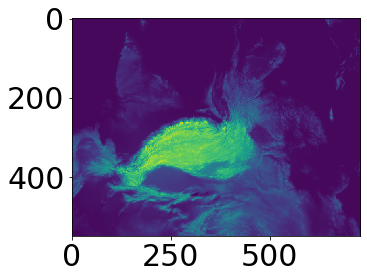

In [184]:
wrfdomain= xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/DEM_TP9km.nc')
dem = wrfdomain.HGT[0].values
plt.imshow(dem)

In [185]:
def weighted_mean(arr, xdim, ydim ,data):
    dataset=xr.DataArray(arr,  dims= {ydim:data[ydim][:].values, xdim:data[xdim][:].values})
    weights = np.cos(np.deg2rad(data['lat'][:]))
    weights.name = "weights"
    data_weighted = dataset.weighted(weights)
    weighted_mean = data_weighted.mean((ydim, xdim), skipna= True)
    return weighted_mean.values

In [186]:
def divergence(data,qu,qv):
    """
    This function calculates the divergence of a given flux.
    Args:
    data: xarray dataset containing coordinate references 
    qu: u-component of 2D flux field (e.g. moisture flux)
    qv: v-component of 2D flux field 
    Returns: 2D field with divergence of the flux. 
    
    """
    import wrf
    import metpy 
    from metpy.units import units
    
    # with metpy derivate function instead of convolution 
    udev = metpy.calc.first_derivative(qu, axis =  -1, delta = 9000 * units.meter) 
    vdev= metpy.calc.first_derivative(qv, axis = -2, delta = 9000 * units.meter)
    arr= np.array(-(vdev+ udev)*86400)
    return np.array(wrf.smooth2d(arr , passes = 3))

In [191]:
thermodynamic_tp_wrf= np.array(())
dynamic_tp_wrf = np.array(())

# read in files for each year 
for y in np.arange(38): 
    sp = xr.open_dataset(sp_files[y]).ps[0].values 
    q_a= xr.open_dataset(anomalies_q[y]).mixr[0].values
    u_a= xr.open_dataset(anomalies_u[y]).u[0].values
    v_a= xr.open_dataset(anomalies_v[y]).v[0].values
    q_c=np.nan_to_num(q_c, 0)
    u_c=np.nan_to_num(u_c, 0)
    v_c=np.nan_to_num(v_c, 0)
    
    q_a=np.nan_to_num(q_a, 0)
    u_a=np.nan_to_num(u_a, 0)
    v_a=np.nan_to_num(v_a, 0)

    
    # product for thermodynamic and dynamic component 
    qc_ua = q_c* u_a 
    qc_va = q_c* v_a
    qa_uc = q_a*u_c
    qa_vc = q_a*v_c
  

    # column-integration   
    dyna_u = atm.colint_pressure(qc_ua, pressure)
    dyna_v = atm.colint_pressure(qc_va, pressure)
    thermo_u = atm.colint_pressure(qa_uc, pressure)
    thermo_v = atm.colint_pressure(qa_vc, pressure)
    
    # divergence 
    thermo= divergence(clim,thermo_u, thermo_v)
    dyna = divergence(clim, dyna_u, dyna_v)

    # calculate regional averages over tp 
    thermo[dem < 3000] = np.nan
    dyna[dem< 3000] = np.nan
    th_tp = weighted_mean(thermo, 'west_east', 'south_north', data)
    dy_tp = weighted_mean(dyna, 'west_east', 'south_north', data)
    
    # append to annual timeseries 
    thermodynamic_tp_wrf = np.append(thermodynamic_tp_wrf,th_tp)
    dynamic_tp_wrf = np.append(dynamic_tp_wrf,dy_tp)



In [260]:
mfc_anomalies = np.zeros((41,))
for t in np.arange(41):
    mfc_anomalies[t] = atm.weighted_mean(mfc_anom[t], climatology)

In [34]:
f= '../moisture_transport/moisture_transport/cache/timeseries/moistdiv_timeseries.nc'
m = xr.open_dataset(f)
moistdiv = -m['vimd'].values[:,0,0]
moistdiv

array([1.5045776, 1.6762466, 1.6330109, 1.545269 , 1.7538166, 1.5859604,
       1.6813316, 1.3990326, 1.4893188, 1.6584435, 1.5999489, 1.8313847,
       1.4982185, 1.462616 , 1.5592575, 1.7563591, 1.655899 , 1.6419144,
       1.5033073, 1.5554428, 1.6686172, 1.5592575, 1.6139374, 1.4702454,
       1.6419144, 1.606308 , 1.6571732, 1.7894211, 1.8758907, 1.7512722,
       1.5605278, 1.7728901, 1.8262978, 1.7131233, 1.8250275, 1.4689713,
       1.3214645, 1.5083923, 1.5287399, 1.6304703, 1.667347 ],
      dtype=float32)

In [160]:
mfc_anomaly = np.load('mean_mfc_tp.npy')
mfc_anomaly_wrf = np.load('mfc_anomaly_wrf.npy')

<Figure size 1440x576 with 0 Axes>

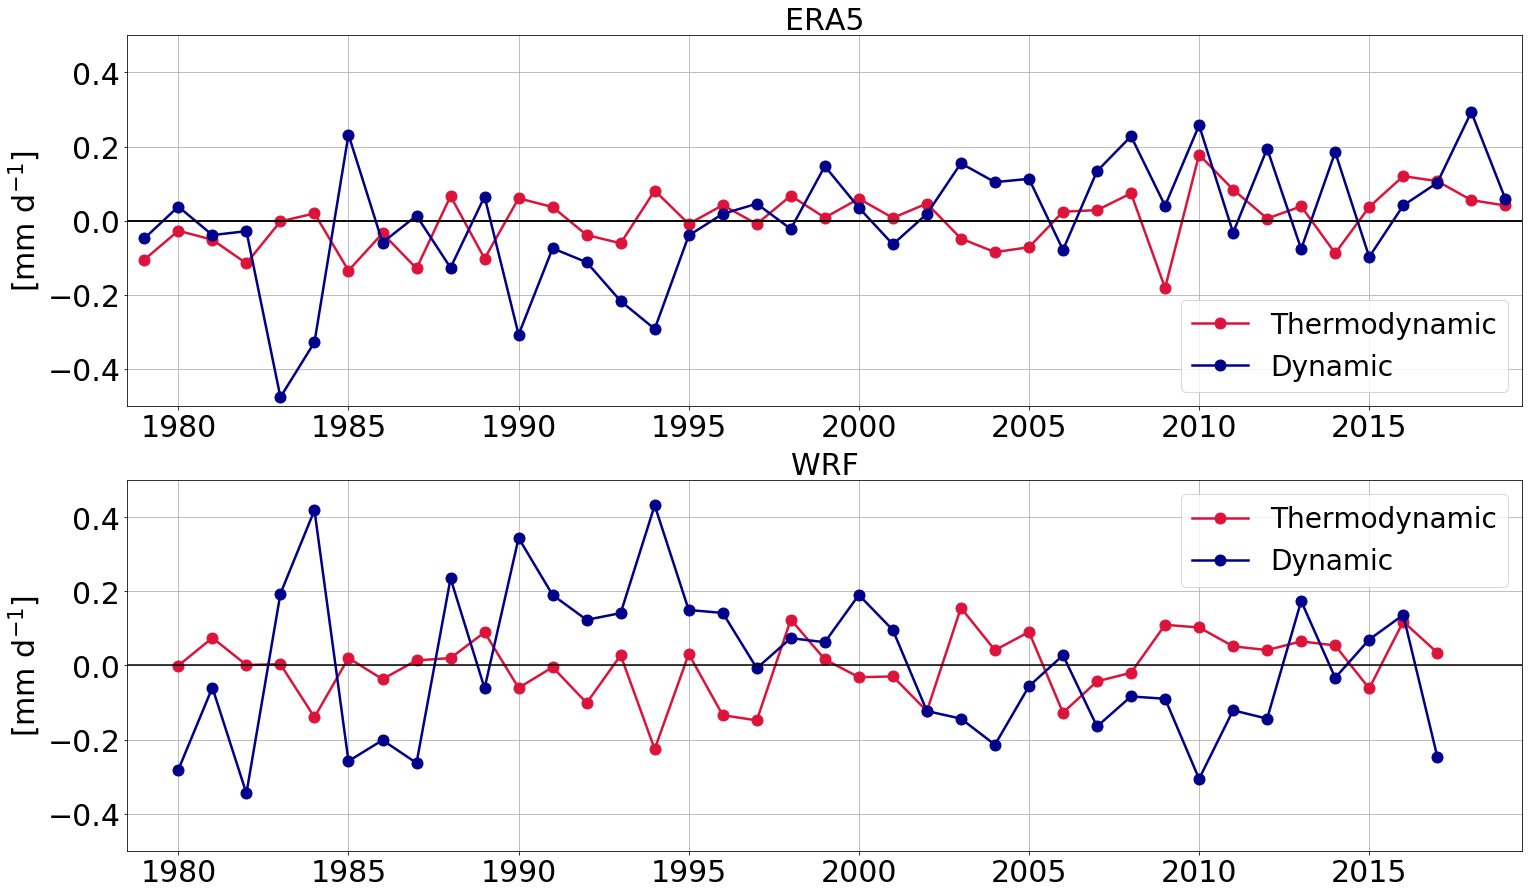

In [173]:
plt.figure(figsize= (20,8))
s= 30

fig, axes = plt.subplots(2, 1, sharex=False, figsize=(25, 15))
time = np.arange(1979,2020)
axes[0].plot(time, thermodynamic_tp, label = 'Thermodynamic', color = 'crimson',marker = 'o', markersize=11, linewidth = 2.5)
axes[0].plot(time, dynamic_tp, label = 'Dynamic', color ='darkblue',marker = 'o', markersize=11,linewidth = 2.5)
#axes[0].bar(time, mfc_anomaly, color = 'lightgray')
axes[0].set_title('ERA5', fontsize= s)
axes[0].axhline(y=0, color='k', linestyle='-')
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[0].set_xticks(time[1::5])
axes[0].set_yticks(np.linspace(-0.4, 0.4, 5))
axes[0].set_ylabel('[mm d$^{-1}$]', fontsize = s)
axes[0].legend(fontsize= 28)
axes[0].grid()

time2 = np.arange(1980,2018)
axes[1].plot(time2, thermodynamic_tp_wrf, label = 'Thermodynamic', color = 'crimson',marker = 'o', markersize=11, linewidth = 2.5)
axes[1].plot(time2, dynamic_tp_wrf, label = 'Dynamic', color ='darkblue',marker = 'o', markersize=11,linewidth = 2.5)

#axes[1].bar(np.arange(1979,2018), mfc_anomaly_wrf, color = 'lightgray')

axes[1].axhline(y=0, color='k', linestyle='-')
axes[1].set_ylim(-0.5, 0.5)
axes[1].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[1].set_xticks(time[1::5])
axes[1].set_yticks(np.linspace(-0.4, 0.4, 5))
axes[1].set_ylabel('[mm d$^{-1}$]', fontsize = s)
axes[0].axhline(y=0, color='k', linestyle='-')
axes[1].set_title('WRF', fontsize= s)
axes[1].legend(fontsize= 28)
axes[1].grid()

plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 

plt.savefig('plots/thermodynamic_dynamic_era5_wrf.png')


<Figure size 1440x576 with 0 Axes>

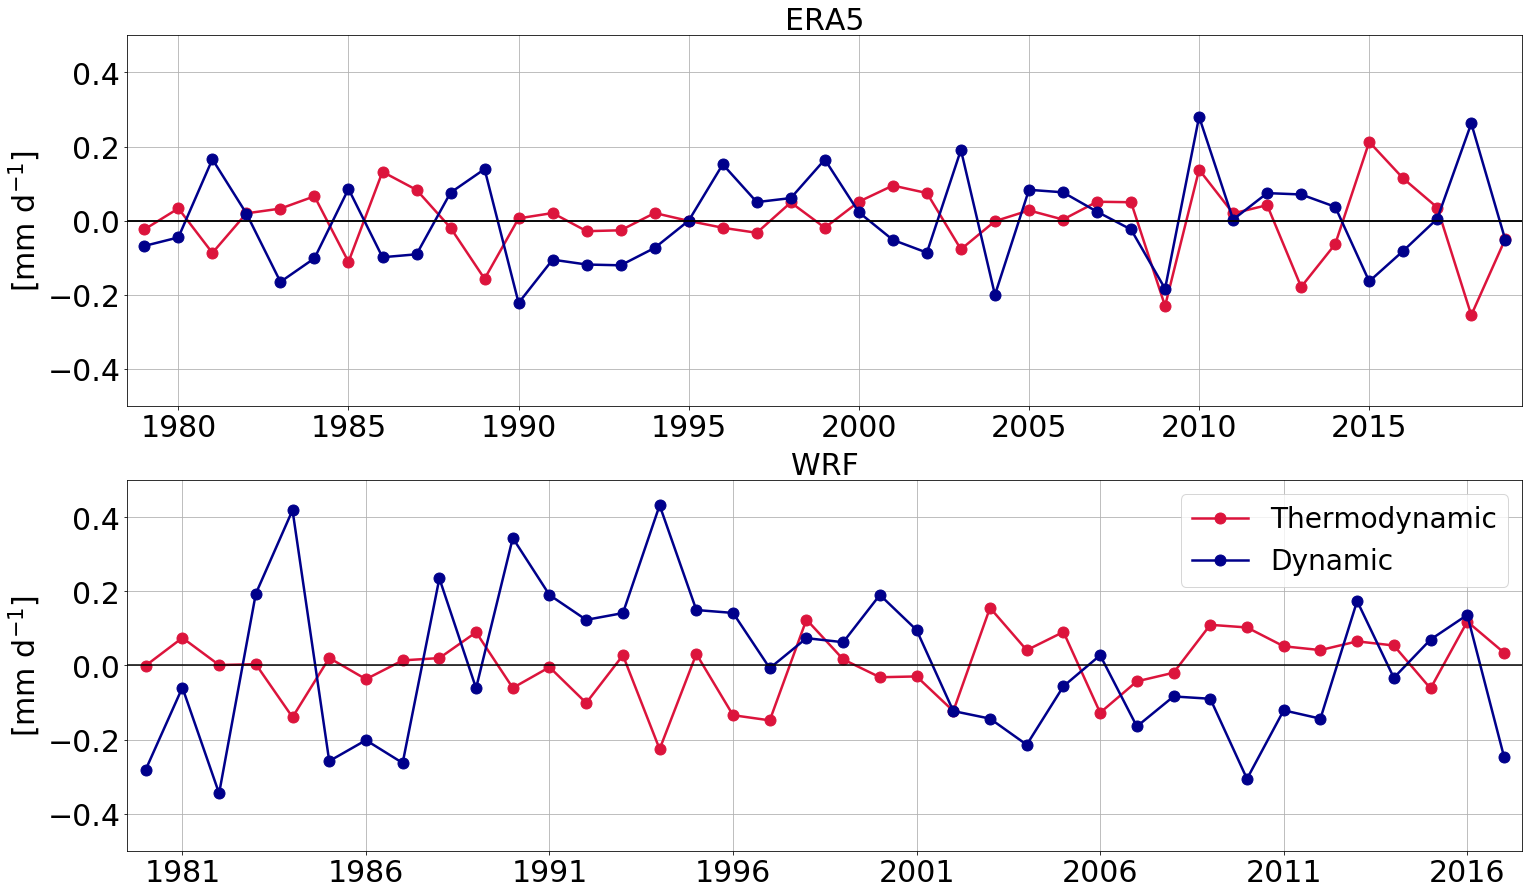

In [48]:
plt.figure(figsize= (20,8))
s= 30

fig, axes = plt.subplots(2, 1, sharex=False, figsize=(25, 15))
time = np.arange(1979,2020)
axes[0].plot(time, thermodynamic_tp, label = 'Thermodynamic', color = 'crimson',marker = 'o', markersize=11, linewidth = 2.5)
axes[0].plot(time, dynamic_tp, label = 'Dynamic', color ='darkblue',marker = 'o', markersize=11,linewidth = 2.5)
#axes[0].bar(time, mfc_anomaly, color = 'lightgray')
axes[0].set_title('ERA5', fontsize= s)
axes[0].axhline(y=0, color='k', linestyle='-')
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[0].set_xticks(time[1::5])
axes[0].set_yticks(np.linspace(-0.4, 0.4, 5))
axes[0].set_ylabel('[mm d$^{-1}$]', fontsize = s)
#axes[0].legend(fontsize= 28)
axes[0].grid()

time = np.arange(1980,2018)
axes[1].plot(time, thermodynamic_tp_wrf, label = 'Thermodynamic', color = 'crimson',marker = 'o', markersize=11, linewidth = 2.5)
axes[1].plot(time, dynamic_tp_wrf, label = 'Dynamic', color ='darkblue',marker = 'o', markersize=11,linewidth = 2.5)
axes[1].axhline(y=0, color='k', linestyle='-')
axes[1].set_ylim(-0.5, 0.5)
axes[1].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[1].set_xticks(time[1::5])
axes[1].set_yticks(np.linspace(-0.4, 0.4, 5))
axes[1].set_ylabel('[mm d$^{-1}$]', fontsize = s)
axes[0].axhline(y=0, color='k', linestyle='-')
axes[1].set_title('WRF', fontsize= s)
axes[1].legend(fontsize= 28)
axes[1].grid()

plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 

plt.savefig('plots/thermodynamic_dynamic_tp_era5_wrf.png')


In [150]:
# Extract timeseries for specific regions 

def mask_region(field):
    ### TP ###
    dem = '/media/juli/Data/projects/data/elevation/GMTED2010_15n030_0125deg.nc'
    elevation = xr.open_dataset(dem)['elevation']
    elevations_tp= elevation[800:1200, 1840:2480]
    lat = np.linspace(800,1199,200)
    lon= np.linspace(1840,2479,320)
    elevs= elevations_tp.interp(nlat= lat, nlon= lon )
    field_tp= field.copy()
    elevs= np.flip(elevs.data, axis  =0)
    field_tp.values[elevs < 3000 ] = np.nan
 
    ### Land ### 
    lm= xr.open_dataset('../moisture_transport/moisture_transport/lsm_era5_tp.nc')['lsm'][0].values
    lsm= np.flip(lm, axis = 0)
    field_land= field.copy()
    field_land.values[lsm == 0] = np.nan

    ### convergence zones ###  
    field_con= field.copy()
    field_con.values[mfc_clim < 0] = np.nan

    ### divergence zones ###
    field_div= field.copy()
    field_div.values[mfc_clim > 0] = np.nan

    # area-weighted means
    mean_tp = atm.weighted_mean(field_tp, climatology)
    mean_land = atm.weighted_mean(field_land, climatology)
    mean_con = atm.weighted_mean(field_con, climatology )
    mean_div = atm.weighted_mean(field_div, climatology) 
    
    return mean_tp, mean_land, mean_con, mean_div

In [122]:
def mask_region_time(field):
    ### TP ###
    dem = '/media/juli/Data/projects/data/elevation/GMTED2010_15n030_0125deg.nc'
    elevation = xr.open_dataset(dem)['elevation']
    elevations_tp= elevation[800:1200, 1840:2480]
    lat = np.linspace(800,1199,200)
    lon= np.linspace(1840,2479,320)
    elevs= elevations_tp.interp(nlat= lat, nlon= lon )
    field_tp= field.copy()
    elevs= np.flip(elevs.data, axis  =0)
    field_tp.values[:, elevs < 3000 ] = np.nan
 
    ### Land ### 
    lm= xr.open_dataset('../moisture_transport/moisture_transport/lsm_era5_tp.nc')['lsm'][0].values
    lsm= np.flip(lm, axis = 0)
    field_land= field.copy()
    field_land.values[:,lsm == 0] = np.nan

    ### convergence zones ###
    field_con= field.copy()
    field_con.values[:,mfc_clim < 0] = np.nan

    ### divergence zones ###
    field_div= field.copy()
    field_div.values[:,mfc_clim > 0] = np.nan   
    
    # area-weighted means timeseries 
    mean_tp = atm.weighted_mean_timeseries(field_tp, climatology)
    mean_land = atm.weighted_mean_timeseries(field_land, climatology)
    mean_con = atm.weighted_mean_timeseries(field_con, climatology )
    mean_div = atm.weighted_mean_timeseries(field_div, climatology) 
    
    
    return mean_tp,mean_land, mean_con, mean_div

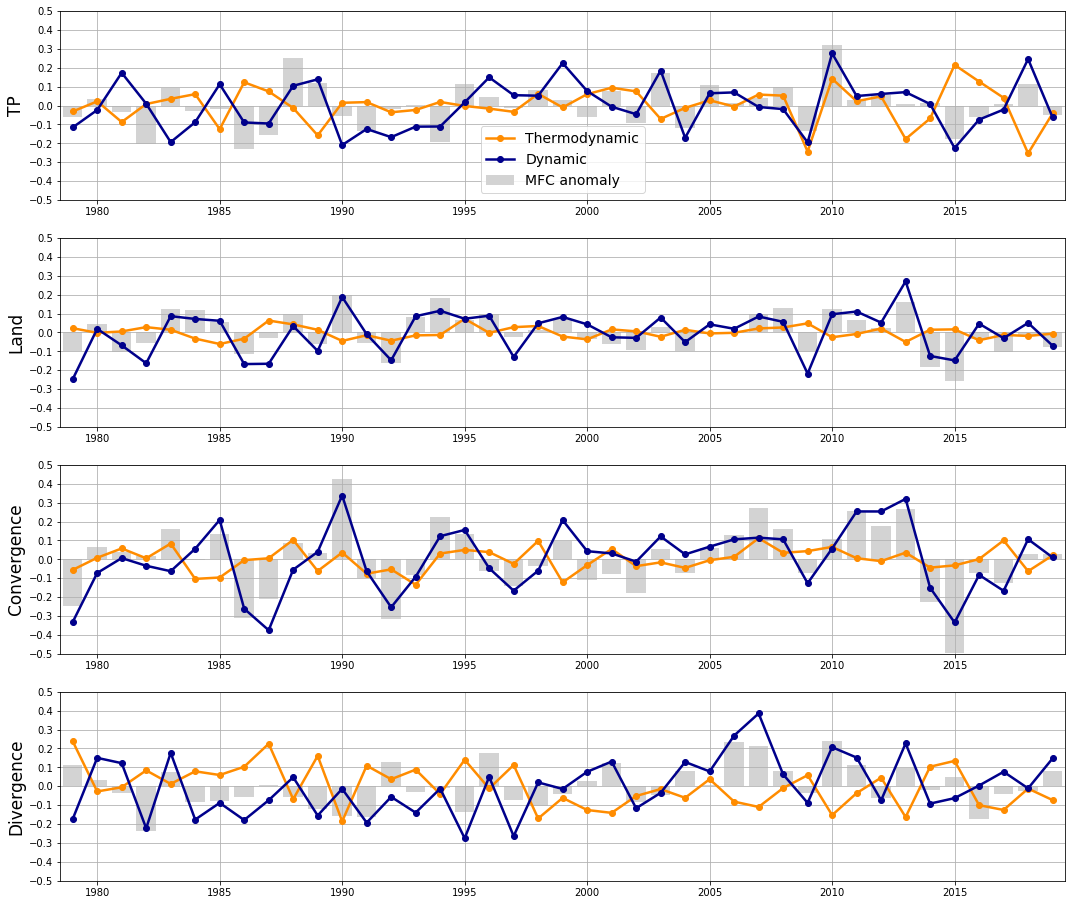

In [17]:
# plot 
s= 17

time = np.arange(1979,2020)

fig, axes = plt.subplots(4, 1, sharex=False, figsize=(18, 16))

axes[0].plot(time, thermodynamic_tp, label = 'Thermodynamic', color = 'darkorange',marker = 'o',  linewidth = 2.5)
axes[0].plot(time, dynamic_tp, label = 'Dynamic', color ='darkblue',marker = 'o', linewidth = 2.5)
axes[0].bar(time, -moistdiv_tp, label = 'MFC anomaly', color ='lightgrey',linewidth = 2.5)
axes[0].set_ylim(-0.3, 0.3)
axes[0].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[0].set_xticks(time[1::5])
axes[0].set_yticks(np.linspace(-0.5, 0.5, 11))
axes[0].set_ylabel('TP', fontsize = s)
axes[0].grid()


axes[1].plot(time, thermodynamic_land, label = 'Thermodynamic', color = 'darkorange',marker = 'o',  linewidth = 2.5)
axes[1].plot(time, dynamic_land, label = 'Dynamic', color ='darkblue',marker = 'o', linewidth = 2.5)
axes[1].bar(time, -moistdiv_land , label = 'MFC anomaly', color ='lightgrey',linewidth = 2.5)
axes[1].set_ylim(-0.3, 0.3)
axes[1].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[1].set_xticks(time[1::5])
axes[1].set_yticks(np.linspace(-0.5, 0.5, 11))
axes[0].legend(fontsize= 14)
axes[1].set_ylabel('Land', fontsize = s)
axes[1].grid()

axes[2].plot(time, thermodynamic_con, label = 'Thermodynamic', color = 'darkorange',marker = 'o',  linewidth = 2.5)
axes[2].plot(time, dynamic_con, label = 'Dynamic', color ='darkblue',marker = 'o', linewidth = 2.5)
axes[2].bar(time, -moistdiv_con , label = 'MFC anomaly', color ='lightgrey',linewidth = 2.5)
axes[2].set_ylim(-0.3, 0.3)
axes[2].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[2].set_xticks(time[1::5])
axes[2].set_yticks(np.linspace(-0.5, 0.5, 11))
axes[2].set_ylabel('Convergence', fontsize = s)
axes[2].grid()


axes[3].plot(time, thermodynamic_div, label = 'Thermodynamic', color = 'darkorange',marker = 'o',  linewidth = 2.5)
axes[3].plot(time, dynamic_div, label = 'Dynamic', color ='darkblue',marker = 'o', linewidth = 2.5)
axes[3].bar(time, -moistdiv_div , label = 'MFC anomaly', color ='lightgrey',linewidth = 2.5)
axes[3].set_ylim(-0.3, 0.3)
axes[3].set_xlim(time[0]-0.5, time[-1]+0.5)
axes[3].set_xticks(time[1::5] )
axes[3].set_yticks(np.linspace(-0.5, 0.5, 11))
axes[3].set_ylabel('Divergence', fontsize = s)
axes[3].grid()


plt.savefig('plots/thermodynamic_dynamic_subregions.png')
plt.show()

## Contributions to MFC anomaly 

In [128]:
slope_tp, intercept_tp, r_value_tp, p_value_tp, std_err = stats.linregress(-moistdiv_tp,dynamic_tp)

In [49]:
from scipy import stats 
slope_land, intercept_land, r_value_land, p_value, std_err = stats.linregress(-moistdiv_land,dynamic_land)
slope_div, intercept_div, r_value_div, p_value, std_err = stats.linregress(-moistdiv_div,dynamic_div)
slope_con, intercept_con, r_value_con, p_value_con, std_err = stats.linregress(-moistdiv_con,dynamic_con)


NameError: name 'moistdiv_land' is not defined

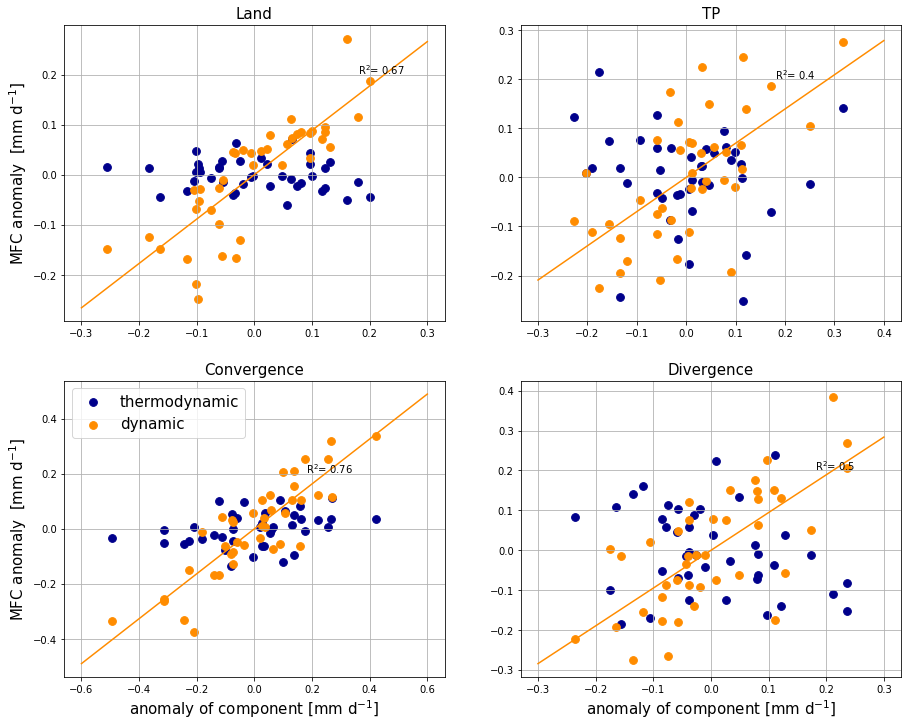

In [32]:
plt.figure(figsize= (15,12))
fs = 15

ax1= plt.subplot(2,2,1)
ax1.set_title('Land', fontsize = 15)
ax1.scatter(-(moistdiv_land),thermodynamic_land, label = 'thermodynamic', color = 'darkblue', s=60)
ax1.scatter(-(moistdiv_land), dynamic_land, label = 'dynamic', color = 'darkorange',s= 60)
x= ax1.get_xticks()
ax1.plot(x,intercept_land + slope_land*x, color= 'darkorange')
ax1.text(0.18,0.2, 'R$^2$= ' + str( np.round(r_value_land**2, decimals=2)) )
ax1.set_ylabel('MFC anomaly  [mm d$^{-1}$]', fontsize = fs)
ax1.grid()

ax2= plt.subplot(2,2,2)
ax2.set_title('TP', fontsize = 15)
ax2.scatter(-(moistdiv_tp),thermodynamic_tp, label = 'thermodynamic', color = 'darkblue', s=60)
ax2.scatter(-(moistdiv_tp), dynamic_tp, label = 'dynamic', color = 'darkorange',s= 60)
#ax2.set_ylabel('total moisture transport [mm d$^{-1}$]', fontsize = fs)
x= ax2.get_xticks()
ax2.plot(x,intercept_tp + slope_tp*x, color= 'darkorange')
ax2.text(0.18,0.2, 'R$^2$= ' + str( np.round(r_value_tp**2, decimals=2)) )
ax2.grid()

ax2= plt.subplot(2,2,4)
ax2.set_title('Divergence', fontsize = 15)
ax2.scatter(-(moistdiv_div),thermodynamic_div, label = 'thermodynamic', color = 'darkblue', s=60)
ax2.scatter(-(moistdiv_div), dynamic_div, label = 'dynamic', color = 'darkorange',s= 60)
#ax2.set_ylabel('total moisture transport [mm d$^{-1}$]', fontsize = fs)
x= ax2.get_xticks()
ax2.plot(x,intercept_div + slope_div*x, color= 'darkorange')
ax2.text(0.18,0.2, 'R$^2$= ' + str( np.round(r_value_div**2, decimals=2)) )
ax2.set_xlabel('anomaly of component [mm d$^{-1}$]', fontsize= fs)
ax2.grid()

ax2= plt.subplot(2,2,3)
ax2.set_title('Convergence', fontsize= 15)
ax2.scatter(-(moistdiv_con),thermodynamic_con, label = 'thermodynamic', color = 'darkblue', s=60)
ax2.scatter(-(moistdiv_con), dynamic_con, label = 'dynamic', color = 'darkorange',s= 60)
#ax2.set_ylabel('total moisture transport [mm d$^{-1}$]', fontsize = fs)
x= ax2.get_xticks()
ax2.plot(x,intercept_con + slope_con*x, color= 'darkorange')
ax2.text(0.18,0.2, 'R$^2$= ' + str( np.round(r_value_con**2, decimals=2)) )
ax2.set_ylabel('MFC anomaly  [mm d$^{-1}$]', fontsize = fs)
ax2.set_xlabel('anomaly of component [mm d$^{-1}$]', fontsize= fs)
ax2.grid()
plt.legend(fontsize= fs)

plt.savefig('plots/thermo_dynam_scatterplot.png')
plt.show()

- TP looks more like divergence zone, while the entire domain is very dominated by the convergence zone pattern -> this emphasizes the dominant role of the monsoon and dynamic horizontal moisture convergence
- evaporation explains an important part of precipitation variability and the thermodynamic component of the moisture transport seems to play a bigger role 